In [48]:
%matplotlib inline
from IPython import display
import matplotlib.pylab as plt
import pandas as pd
import numpy as np

In [49]:
prefix = '1to13'
path = '/astro/store/gradscratch/tmp/scw7/tessData/lightcurves/sec1to13/'
log_path = path + 'log/'
plots_path = path + 'plots_filt/'

In [50]:
df = pd.read_csv(log_path + prefix + '_flare_out.csv')
df_param = pd.read_csv(log_path + prefix + '_param_out.csv')
mask = (df['skew'] > 0.5) & (df['f_chisq'] > 0) & (df['f_fwhm_win'] < 0.1) & \
       (df['tpeak'] > df['t0']) & (df['tpeak'] < df['t1']) & (df['cover'] > 0.9) & (df['f_chisq']/df['g_chisq'] < 0.7)
print(len(df), len(df[mask]), len(np.unique(df[mask]['file'])))

df_flare = df[mask]
flare_files = np.unique(df_flare['file'])

393304 16874 7154


In [51]:
def disp_fl(filename):
    lc_file = plots_path + filename + '.png'
    flare_file = plots_path + filename + '_flares.png'
    display.display(filename)
    display.display(display.Image(lc_file))
    display.display(display.Image(flare_file))

In [53]:
# Compare with Tu 2019
TIC1 = 121011020 # Should be a detection at t=1431
TIC2 = 231631019 # Should be a detection at 1343, but very weak and didnt follow psf
TIC3 = 43472154 # 200 superflares / yr
df_flare[df_flare['TIC'] == TIC1]

,TIC,cover,ed,ed_err,f_amp,f_amp_err,f_chisq,f_fwhm_win,file,fwhm,...,mu,mu_err,peak_flux,skew,std,std_err,t0,t1,tpeak,tpeak_err
392779,121011020.0,0.982684,0.000685,0.000003,0.102603,0.001774,14.772910,0.013358,tess2018292075959-s0004-0000000121011020-0124-...,0.004286,...,1425.084513,0.000131,76420.921875,1.850145,0.003366,0.000136,1424.934892,1425.255729,1425.082432,0.000029
392782,121011020.0,1.000000,0.001301,0.000003,0.196766,0.003379,43.382334,0.011240,tess2018292075959-s0004-0000000121011020-0124-...,0.004121,...,1431.539640,0.000149,79671.757812,1.798704,0.004085,0.000148,1431.368260,1431.734926,1431.536877,0.000027


'tess2018319095959-s0005-0000000152573312-0125-s_lc.fits'

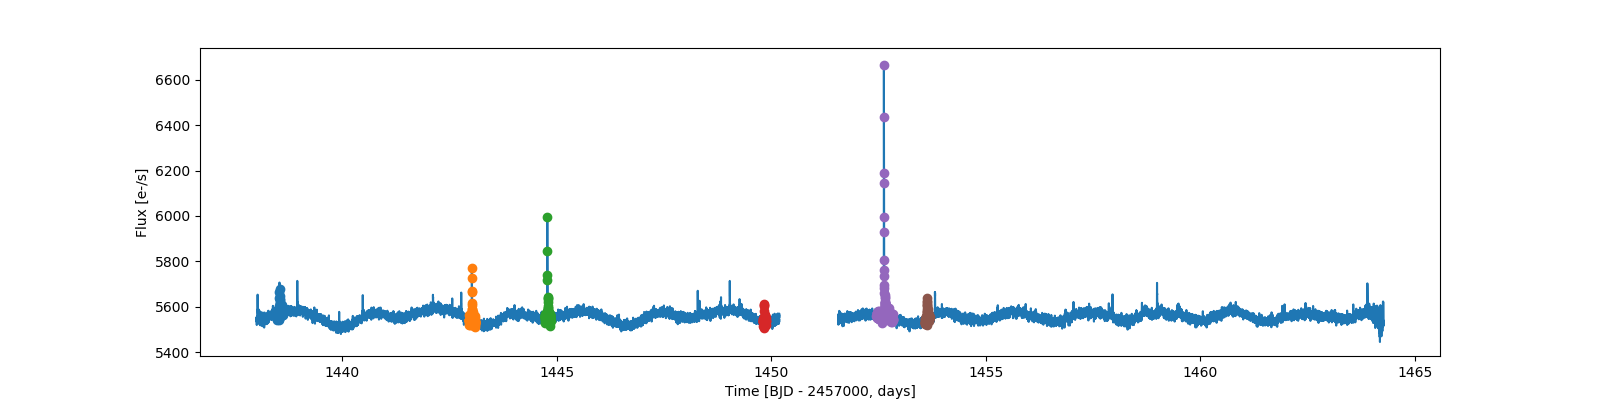

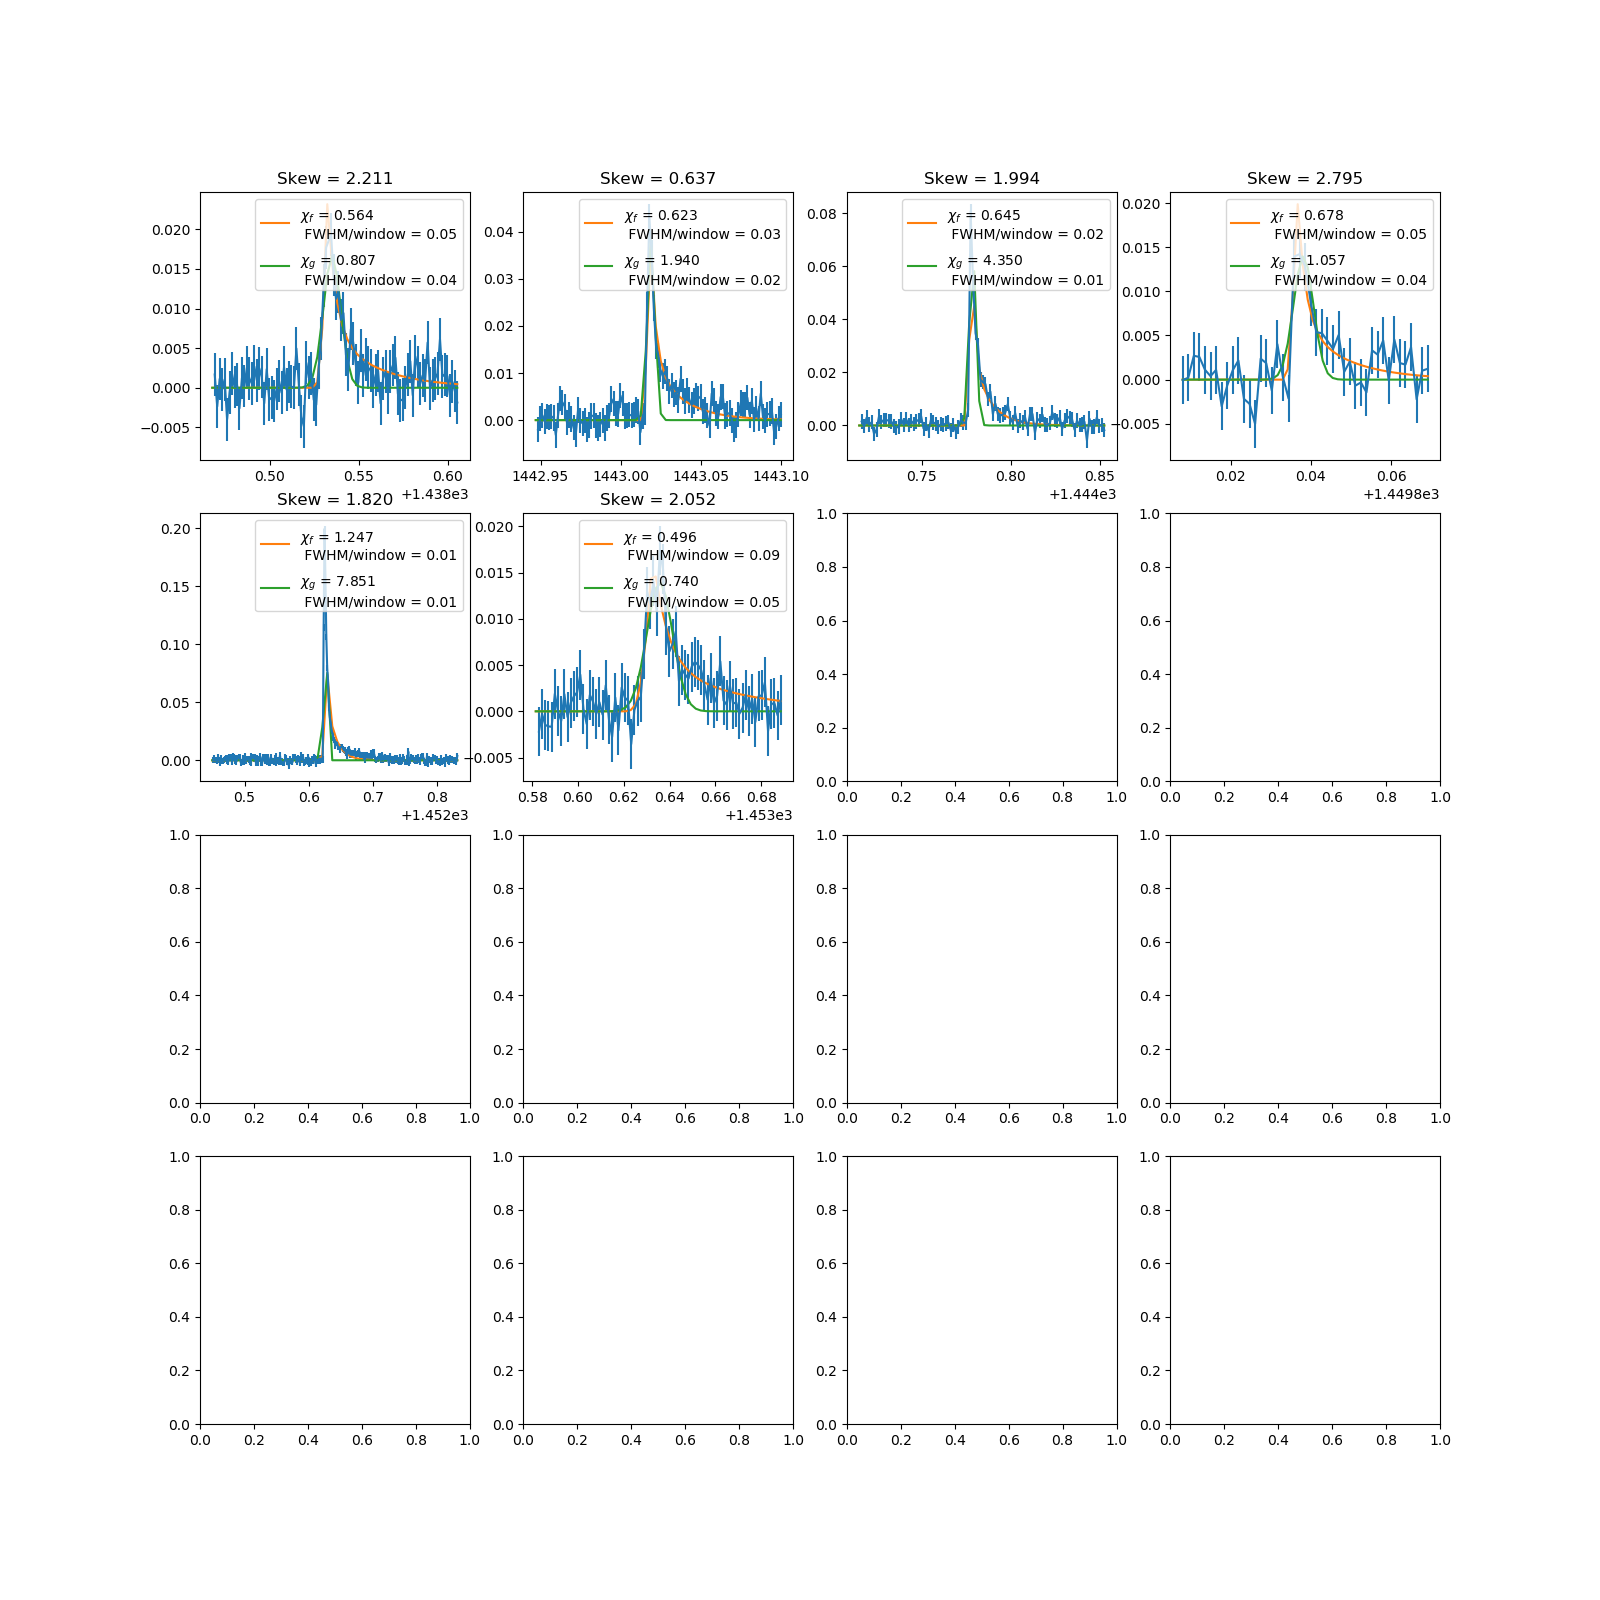

In [24]:
disp_fl(df['file'].iloc[0])